In [ ]:
%cd ..

import os
import torch
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torchvision
from PIL import Image

from utils import image_normalization
from dataset import Vanilla
from alignment.alignment_utils import load_deep_jscc
from alignment.alignment_model import AlignedDeepJSCC
from alignment.alignment_training import *
from alignment.alignment_validation import *

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": True,
    'font.size': 12,
})

/home/lorenzo/repos/Deep-JSCC-PyTorch


In [2]:
autoencoders_folder = r'alignment/models/autoencoders'
plot_folder = "all_models"
os.makedirs(f'alignment/models/plots/{plot_folder}', exist_ok=True)
os.makedirs(f'alignment/models/plots/{plot_folder}/images', exist_ok=True)

dataset = "cifar10"
resolution = 96
n_samples = 10000
batch_size = 64
num_workers = 4

c = 8
types = ["conv", "twoconv", "neural", "mlp", "zeroshot", "linear", "unaligned", "no_mismatch"]
snrs = [-20, -10, 0, 10, 20, 30]
seeds = [42, 43]
seed = 42

upscale_factor = 1
image_path = r'demo/kodim23_particolare.png'

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

train_loader, test_loader = get_data_loaders(dataset, resolution, batch_size, num_workers)

# Train

In [ ]:
for snr in snrs:
    model1_fp = f'{autoencoders_folder}/snr_{snr}_seed_{seeds[0]}.pkl'
    model2_fp = f'{autoencoders_folder}/snr_{snr}_seed_{seeds[1]}.pkl'    

    data = load_alignment_dataset(model1_fp, model2_fp, snr, train_loader, c, device)

    set_seed(seed)
    permutation = torch.randperm(len(data))

    # linear
    data.flat = True
    aligner = train_linear_aligner(data, permutation, n_samples, snr)
    aligner_fp = f'alignment/models/plots/{plot_folder}/aligner_linear_{snr}.pth'
    torch.save(aligner.state_dict(), aligner_fp)

    # neural
    data.flat = False
    aligner, epoch = train_neural_aligner(data, permutation, n_samples, batch_size, resolution, 6, snr, device)
    aligner_fp = f'alignment/models/plots/{plot_folder}/aligner_neural_{snr}.pth'
    torch.save(aligner.state_dict(), aligner_fp)

    # mlp
    data.flat = False
    aligner, epoch = train_mlp_aligner(data, permutation, n_samples, batch_size, resolution, 6, snr, device)
    aligner_fp = f'alignment/models/plots/{plot_folder}/aligner_mlp_{snr}.pth'
    torch.save(aligner.state_dict(), aligner_fp)

    # conv
    data.flat = False
    aligner, epoch = train_conv_aligner(data, permutation, n_samples, c, batch_size, snr, device)
    aligner_fp = f'alignment/models/plots/{plot_folder}/aligner_conv_{snr}.pth'
    torch.save(aligner.state_dict(), aligner_fp)

    # twoconv
    data.flat = False
    aligner, epoch = train_twoconv_aligner(data, permutation, n_samples, c, batch_size, snr, device)
    aligner_fp = f'alignment/models/plots/{plot_folder}/aligner_twoconv_{snr}.pth'
    torch.save(aligner.state_dict(), aligner_fp)

    # zeroshot
    data.flat = True
    aligner = train_zeroshot_aligner(data, permutation, n_samples, snr, n_samples, device)
    aligner_fp = f'alignment/models/plots/{plot_folder}/aligner_zeroshot_{snr}.pth'
    torch.save(aligner.state_dict(), aligner_fp)

    print(f"Done with {snr}.")

Caching inputs: 100%|██████████| 782/782 [00:04<00:00, 173.52it/s]


Done with 30.


# Plot

In [4]:
for snr in snrs:
    model1_fp = f'{autoencoders_folder}/snr_{snr}_seed_{seeds[0]}.pkl'
    model2_fp = f'{autoencoders_folder}/snr_{snr}_seed_{seeds[1]}.pkl'

    encoder = copy.deepcopy(load_deep_jscc(model1_fp, snr, c, "AWGN").encoder)
    decoder = copy.deepcopy(load_deep_jscc(model2_fp, snr, c, "AWGN").decoder)

    for type in types:
        aligner_fp = f'alignment/models/plots/{plot_folder}/aligner_{type}_{snr}.pth'
        output_path = f'alignment/models/plots/{plot_folder}/images/{type}_{snr}.png'        

        if type == "unaligned":
            aligned_model = AlignedDeepJSCC(encoder, decoder, None, snr, "AWGN")

        elif type == "no_mismatch":
            aligned_model = AlignedDeepJSCC(encoder, copy.deepcopy(load_deep_jscc(model1_fp, snr, c, "AWGN").decoder), None, snr, "AWGN")
        
        else:
            aligner = prepare_aligner(aligner_fp, device, resolution, c, n_samples)
            print(type)
            print(sum(p.numel() for p in aligner.parameters()))
            aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, "AWGN")

        get_image_aligner(aligned_model, image_path, output_path, resolution, upscale_factor)

conv
6416
twoconv
12833
neural
84934656
mlp
169887745
zeroshot
284330001
linear
84934656
conv
6416
twoconv
12833
neural
84934656
mlp
169887745
zeroshot
284330001
linear
84934656
conv
6416
twoconv
12833
neural
84934656
mlp
169887745
zeroshot
284330001
linear
84934656
conv
6416
twoconv
12833
neural
84934656
mlp
169887745
zeroshot
284330001
linear
84934656
conv
6416
twoconv
12833
neural
84934656
mlp
169887745
zeroshot
284330001
linear
84934656
conv
6416
twoconv
12833
neural
84934656
mlp
169887745
zeroshot
284330001
linear
84934656


Plots saved as:
  PDF: output/methods_vs_snr_on_image.pdf
  PNG: output/methods_vs_snr_on_image.png


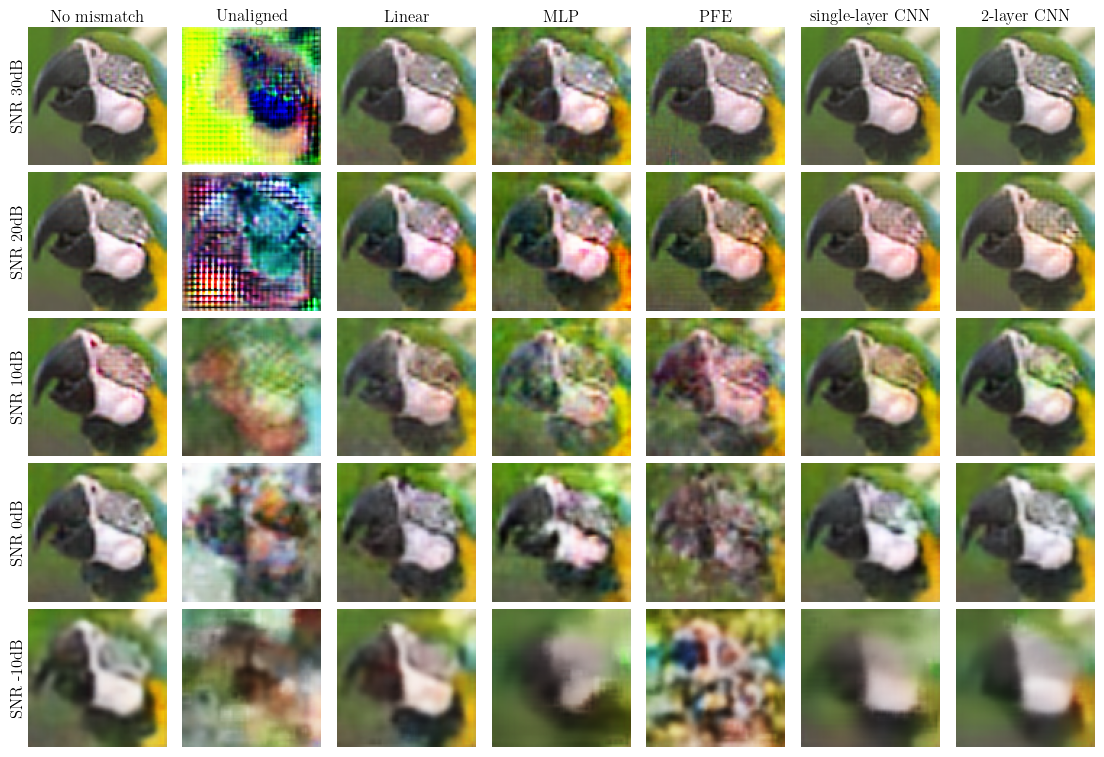

In [3]:
num_rows = 5
num_cols = 7
batch_size = num_rows * num_cols

# row_titles = ["SNR -10dB", "SNR 0dB", "SNR 10dB", "SNR 20dB", "SNR 30dB"]
row_titles = ["SNR 30dB", "SNR 20dB", "SNR 10dB", "SNR 0dB", "SNR -10dB"]
# row_path = ["-10", "0", "10", "20", "30"]
row_path = ["30", "20", "10", "0", "-10"]
col_titles = ["No mismatch", "Unaligned", "Linear", "MLP", "PFE", "single-layer CNN", "2-layer CNN"]
col_path = ["no_mismatch", "unaligned", "linear", "mlp", "zeroshot", "conv", "twoconv"]

fig, axes = plt.subplots(num_rows, num_cols, 
                        figsize=(12, 8),
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.02})

axes = np.atleast_2d(axes)
if axes.shape[0] == 1 and num_rows > 1:
    axes = axes.T

for i in range(num_rows): 
    for j in range(num_cols): 
        image_path = r'alignment/models/plots/'+plot_folder+'/images/' + col_path[j] + "_" + row_path[i] + ".png" 
        
        ax = axes[i, j] if num_rows > 1 else axes[0, j]
        
        try:
            img = Image.open(image_path).convert('RGB') 
            ax.imshow(img) 
            
        except FileNotFoundError:
            ax.text(0.5, 0.5, f'Missing:\n{col_path[j]}_{row_path[i]}', 
                   ha='center', va='center', transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='lightgray'))
        
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        if i == 0:
            ax.text(0.5, 1.02, col_titles[j], ha='center', va='bottom',  
                   transform=ax.transAxes, fontweight='bold')
        
        if j == 0:
            ax.text(-0.02, 0.5, row_titles[i], ha='right', va='center',
                   transform=ax.transAxes, fontweight='bold', 
                   rotation=90)

plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.02, 
                   hspace=0.05, wspace=0.02)

os.makedirs('output', exist_ok=True)

filename = f"methods_vs_snr_on_image"

pdf_path = os.path.join('output', f"{filename}.pdf")
png_path = os.path.join('output', f"{filename}.png")

plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')

print(f"Plots saved as:")
print(f"  PDF: {pdf_path}")
print(f"  PNG: {png_path}")

plt.show()

/home/lorenzo/repos/Deep-JSCC-PyTorch
Plots saved as:
  PDF: output/high_res_comparison.pdf
  PNG: output/high_res_comparison.png


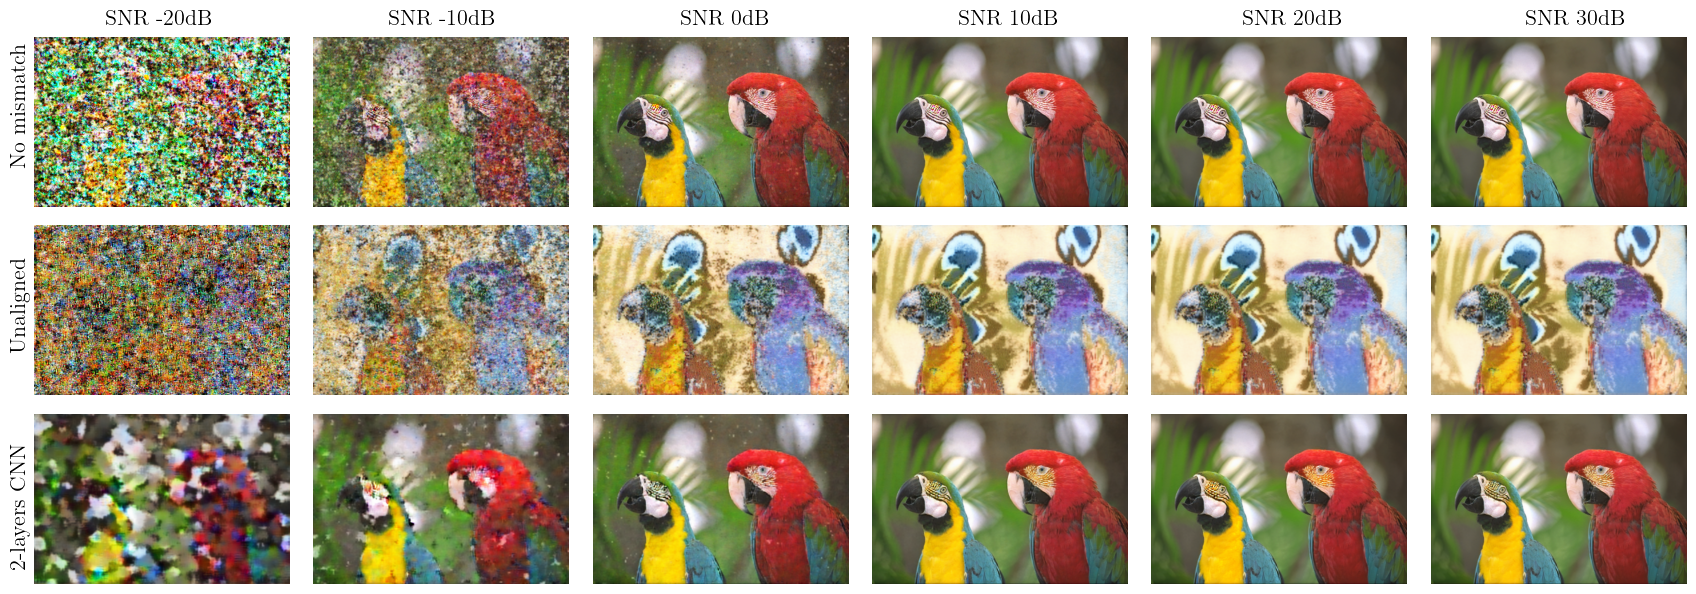

In [ ]:
num_rows = 3
num_cols = 6
batch_size = num_rows * num_cols

# Load CIFAR-10
transform = transforms.ToTensor()

# Class names and custom headers
row_titles = ["No mismatch", "Unaligned", "2-layers CNN"]
row_path = ["no_mismatch", "unaligned", "aligned"]
col_titles = ["SNR -20dB", "SNR -10dB", "SNR 0dB", "SNR 10dB", "SNR 20dB", "SNR 30dB"]
col_path = ["-20", "-10", "0", "10", "20", "30"]

# Create grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(17, 6))

for i in range(num_rows):
    for j in range(num_cols):
        image_path = f"alignment/models/plots/high_Res/images/{row_path[i]}_{col_path[j]}.png"

        idx = i * num_cols + j
        img = Image.open(image_path).convert('RGB')
        ax = axes[i, j]

        ax.imshow(img)
        ax.axis('off')
        #ax.set_title(class_names[label], fontsize=8)

# Add column titles
for j, title in enumerate(col_titles):
    fig.text(
        0.088 + j / num_cols, 0.975,  # x, y position in figure coords
        title,
        ha='center',
        fontweight='bold'
    )

# Add row titles
for i, title in enumerate(row_titles):
    fig.text(
        0, 0.84 - i / num_rows,  # x, y position in figure coords
        title,
        va='center',
        fontweight='bold',
        rotation='vertical'
    )

plt.tight_layout()

filename = f"high_res_comparison"

pdf_path = os.path.join('output', f"{filename}.pdf")
png_path = os.path.join('output', f"{filename}.png")

plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')

print(f"Plots saved as:")
print(f"  PDF: {pdf_path}")
print(f"  PNG: {png_path}")

plt.show()